# Rossman Store Sales Prediction

# Steps:
1. Explatory Data Analysis
2. Time Series Analysis
    2.1. Predictive Modeling
    2.2. RNN(LSTM) modeling
3. Results

## Used dataset is **rossmann store data**. It operates over 3,000 drug stores in 7 European countries. The challenge is to predict their daily sales for up to six weeks in advance.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
store = pd.read_csv('store.csv')
train = pd.read_csv('train.csv', index_col='Date', parse_dates=True)
test = pd.read_csv('test.csv')


C:\Users\Dsy\AppData\Local\Temp\ipykernel_13340\1526105936.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv', index_col='Date', parse_dates=True)


In [10]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [11]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [12]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Display shapes of the datasets

In [3]:
print(train.shape, test.shape, store.shape)

(1017209, 8) (41088, 8) (1115, 10)


# 1. Exploratory Data Analysis (EDA)

In [4]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekofYear'] = train.index.isocalendar().week
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

## Check when the store was closed

In [5]:
train_store_closed = train[(train.Open == 0)]
print(train_store_closed.head())

            Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31    292          5      0          0     0      1            0   
2015-07-31    876          5      0          0     0      1            0   
2015-07-30    292          4      0          0     0      1            0   
2015-07-30    876          4      0          0     0      1            0   
2015-07-29    292          3      0          0     0      1            0   

            SchoolHoliday  Year  Month  Day  WeekofYear  SalesPerCustomer  
Date                                                                       
2015-07-31              1  2015      7   31          31               NaN  
2015-07-31              1  2015      7   31          31               NaN  
2015-07-30              1  2015      7   30          31               NaN  
2015-07-30              1  2015      7   30          31               NaN  
2015-07-29 

## Plot histogram of the days when the store was closed

<Axes: >

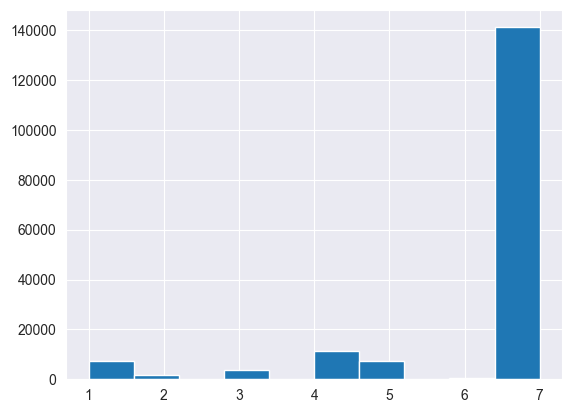

In [6]:
train_store_closed['DayOfWeek'].hist()

From this chart, we could see that, 7th day store was mostly clodes. It is Sunday and makes sense.

## Check whether the school was closed for holidays

<Axes: xlabel='SchoolHoliday'>

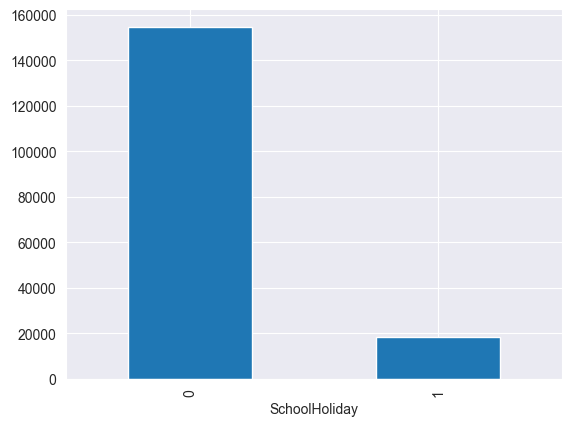

In [7]:
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar')

Here 1 is school closed day and it pretty low. And 0 is None.

<Axes: xlabel='StateHoliday'>

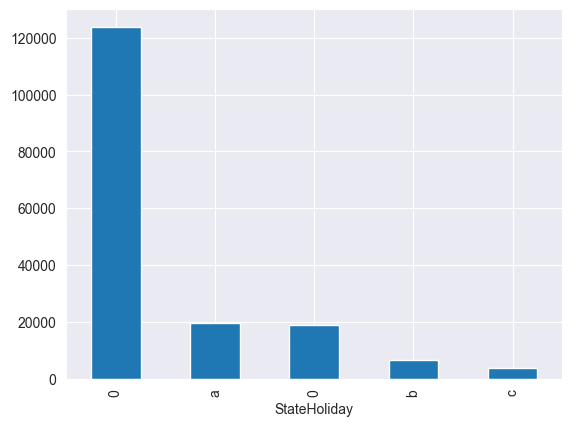

In [8]:
# Check whether the state was closed for holidays
train_store_closed['StateHoliday'].value_counts().plot(kind='bar')


Here, The state is closed for (a= Public holyday, b = Easter holyday, c = Christmas and 0 is None)

## Check for null values in the train dataset

In [9]:
print(train.isnull().sum())

Store                    0
DayOfWeek                0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Year                     0
Month                    0
Day                      0
WeekofYear               0
SalesPerCustomer    172869
dtype: int64


## Number of days with closed stores

In [13]:
train[(train.Open == 0)].shape[0]

172817

## Okay now check No. of dayes store open but sales zero ( It might be caused by external refurbishmnent)

In [14]:
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

# Check null values for store.csv

In [15]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [16]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
store.fillna(0, inplace=True)
store.isnull().sum().sum()

0

## check null values ( Only one feature Open is empty)

In [17]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [18]:
test.fillna(1, inplace=True)
test.isnull().sum().sum()

0

# Join train and store table

In [19]:

train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [21]:
grouped_data = train_store_joined.groupby('StoreType')[['Customers', 'Sales', 'SalesPerCustomer']].sum().sort_values('Sales', ascending=False)
print(grouped_data)

           Customers       Sales  SalesPerCustomer
StoreType                                         
a          363541434  3165334859      4.043129e+06
d          156904995  1765392943      2.918350e+06
c           92129705   783221426      9.744876e+05
b           31465621   159231395      7.987612e+04


In [22]:
train_store_joined[(train_store_joined.Open == 0) | (train_store_joined.Sales==0)].shape

(172871, 22)

So, we have 172,871 observations when the stores were closed or have zero sales.

## Open & Sales >0 stores

In [23]:

train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]
train_store_joined_open

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,1,6905,471,1,1,0,1,2013,1,...,14.660297,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017204,1115,6,4771,339,1,0,0,1,2013,1,...,14.073746,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,4540,326,1,0,0,1,2013,1,...,13.926380,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,4297,300,1,0,0,1,2013,1,...,14.323333,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


# Correlation Analysis

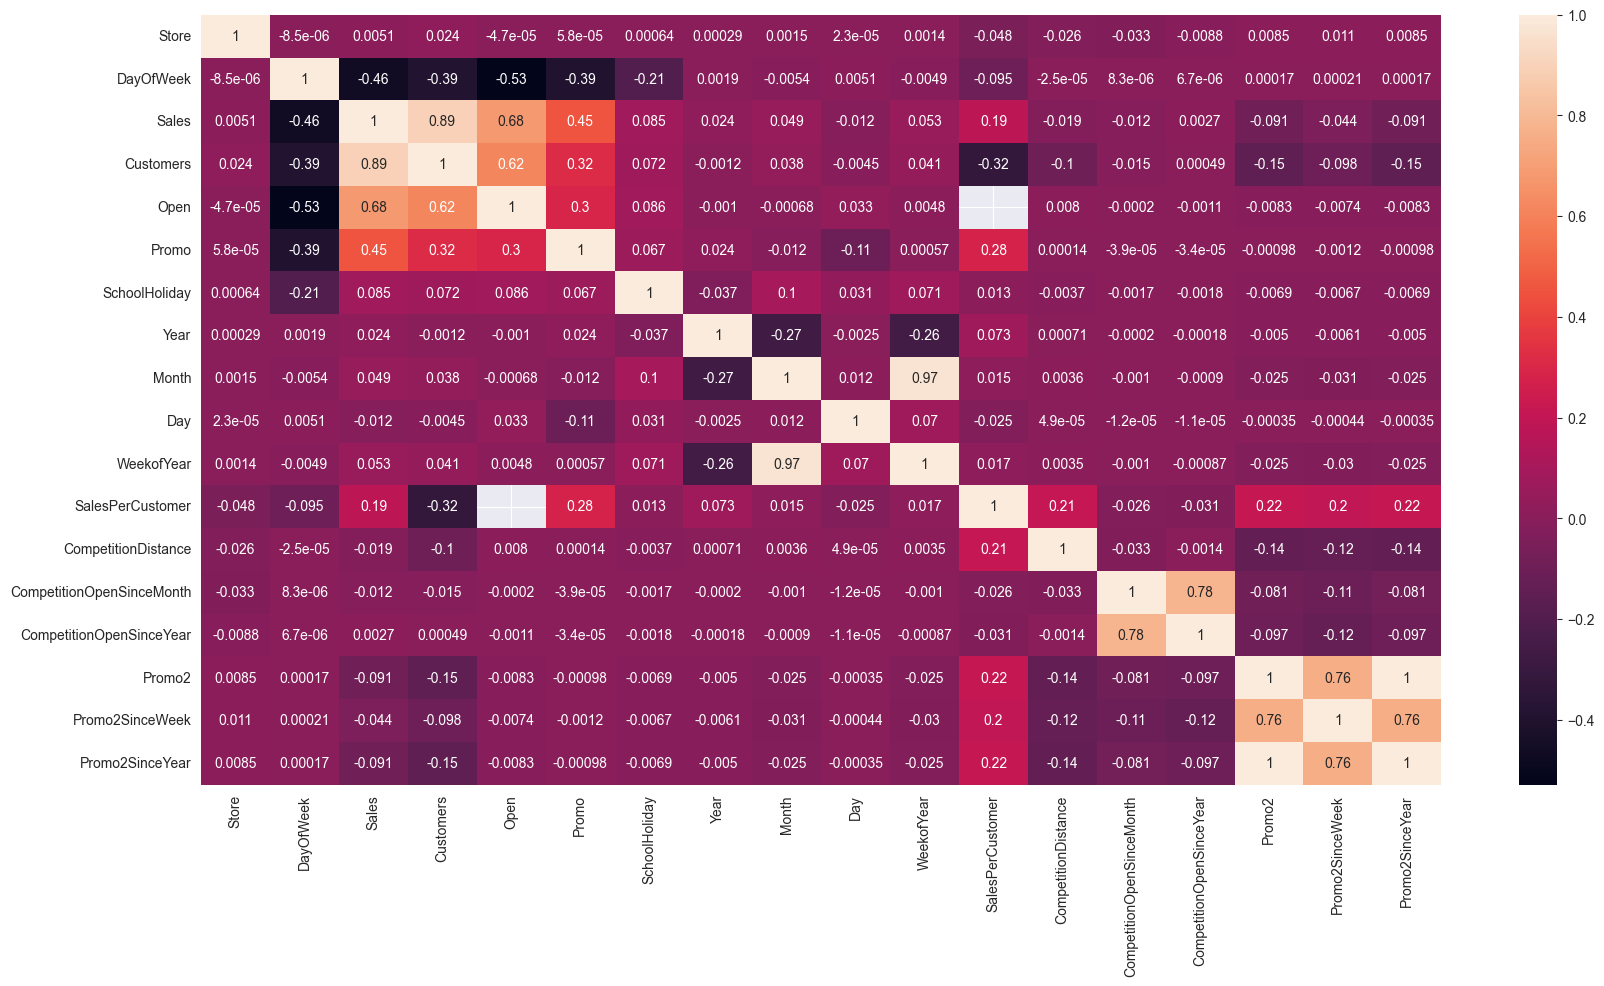

In [26]:
numeric_columns = train_store_joined.select_dtypes(include=[np.number])
plt.figure(figsize=(20, 10))
sns.heatmap(numeric_columns.corr(), annot=True)
plt.show()